# AllLife Bank Customer Segmentation

## Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

## Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


## Key Questions

- How many different types (clusters/segments) of customers can be found from the data?
- How do these different groups of customers differ from each other?
- Do you get slightly different solutions from two different techniques? How would you explain the difference?


## Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

 
**Data Dictionary**

`SlNo`: Primary key of the records

`Customer Key`: Customer identification number

`Average Credit Limit`: Average credit limit of each customer for all credit cards

`Total credit cards`: Total number of credit cards possessed by the customer

`Total visits bank`: Total number of Visits that customer made (yearly) personally to the bank

`Total visits online`: Total number of visits or online logins made by the customer (yearly)

`Total calls made`: Total number of calls made by the customer to the bank or its customer service department (yearly)

# EDA

### Importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import (
    dendrogram,
    linkage,
    cophenet,
)  # Pairwise distribution between data points

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

<IPython.core.display.Javascript object>

In [2]:
# loading the dataset
data = pd.read_csv("CreditCardCustomerData.csv")

<IPython.core.display.Javascript object>

In [3]:
# print the shape of df
data.shape

(660, 7)

<IPython.core.display.Javascript object>

* The dataset has 660 rows and 7 columns 

In [4]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [5]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

<IPython.core.display.Javascript object>

In [6]:
# print column names
df.columns

Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

<IPython.core.display.Javascript object>

In [7]:
# rename the columns
df.rename(
    inplace=True,
    columns={
        "Sl_No": "SlNo",
        "Customer Key": "CustomerKey",
        "Avg_Credit_Limit": "AvgCreditLimit(USD)",
        "Total_Credit_Cards": "TotalCreditCards",
        "Total_visits_bank": "TotalVisitsBank(Yearly)",
        "Total_visits_online": "TotalVisitsOnline(Yearly)",
        "Total_calls_made": "TotalCallsMade(Yearly)",
    },
)

<IPython.core.display.Javascript object>

## Sanity Check

Because we want to generalize this subsample of customers to all our customers, and all possible customers, we want to have unique values in each group and so we can drop duplicates because we care not about the number of identifiers in the group but the number of groups and their differences.

In [8]:
# check for duplicates in a column
df[df.duplicated(keep=False)]

,SlNo,CustomerKey,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly)


<IPython.core.display.Javascript object>

Let's drop the duplicate customers and assume that the last customer entry or the latter one is the lastest and most up-to-date customer information.

In [9]:
# drop duplicate rows
df.drop_duplicates(keep="last", inplace=True)

<IPython.core.display.Javascript object>

*From GreatLearning*:
    
    The Customer Key is a unique ID given to each customer in the database, and can be ignored during the analysis. In real-world context I would need to go back to source of the data and discuss what happened with the duplicate Customer Keys.

In [10]:
# perhaps
df.duplicated(subset=("CustomerKey"))

0      False
1      False
2      False
3      False
4      False
       ...  
655    False
656    False
657    False
658    False
659    False
Length: 660, dtype: bool

<IPython.core.display.Javascript object>

In [11]:
# dropping the serial no. column and customer key as it does not provide any information
df.drop(labels=["SlNo", "CustomerKey"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [12]:
# print information of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   AvgCreditLimit(USD)        660 non-null    int64
 1   TotalCreditCards           660 non-null    int64
 2   TotalVisitsBank(Yearly)    660 non-null    int64
 3   TotalVisitsOnline(Yearly)  660 non-null    int64
 4   TotalCallsMade(Yearly)     660 non-null    int64
dtypes: int64(5)
memory usage: 30.9 KB


<IPython.core.display.Javascript object>

**Observations**
- After dropping duplcate customers we only loss 16 records.

- `Customer Key` is a categorical variable with 660 unique categories or kinds of customers that indicate each customer's name within the dataset, stated numerically. It is dropped because it does not help us bucket the customers since it is a unique value for each customer.

- The 5 `Total` variables are of type *int* (integer) and are quantative variables.

In [13]:
# get statistical summary
df.describe()

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly)
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


<IPython.core.display.Javascript object>

**Observations**

- The median value of `Avg_Credit_Limit` is 34,574, indicating that most of the bank's customers have a low credit limit.
- The mean and median of other `Totals` lie between 0 and 15, except the mean infrastructure rating.

In [14]:
# checking for missing values
df.isna().sum()

AvgCreditLimit(USD)          0
TotalCreditCards             0
TotalVisitsBank(Yearly)      0
TotalVisitsOnline(Yearly)    0
TotalCallsMade(Yearly)       0
dtype: int64

<IPython.core.display.Javascript object>

- There are no missing values in our data

### Univariate Visualizations

In [15]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

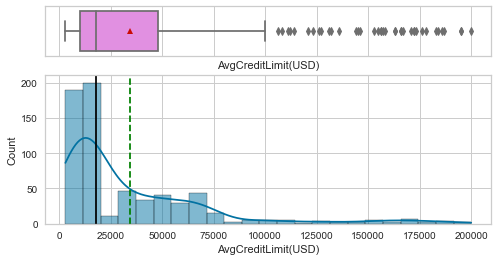

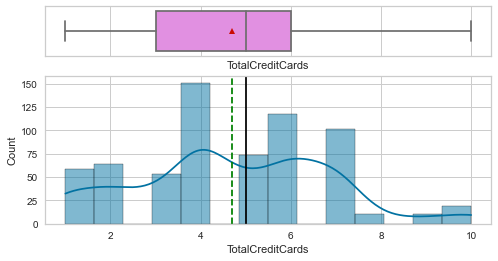

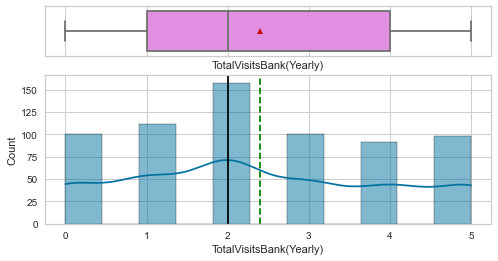

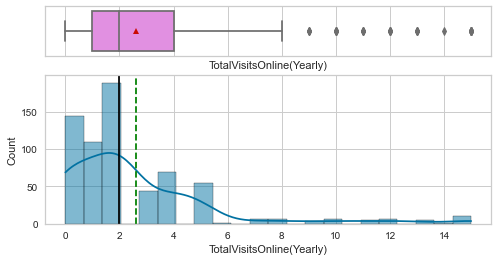

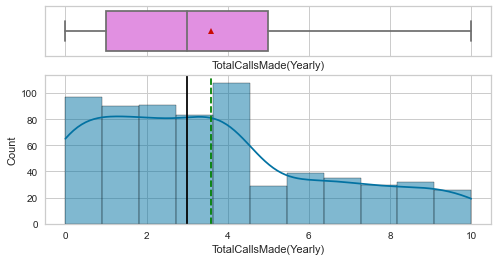

<IPython.core.display.Javascript object>

In [16]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item, kde=True, figsize=(8, 4))

**Observations**

`Average Credit Limit`: Average credit limit of each customer for all credit cards: is right skewed and shows that most of the customers have a limit below 25000. There are many outliers in the higher range. There seems to be a grouping from 1 to ~15k , then 15k - 75k , then 75k and up.

`Total credit cards`: Total number of credit cards possessed by the customer: The mean is a little less than 5 and the median is around 5. There are two peaks: one at 4 and one at 6.

`Total visits bank`: Total number of Visits that customer made (yearly) personally to the bank: The middle visit value is 2.

`Total visits online`: Total number of visits or online logins made by the customer (yearly): The average lies around 3. There are many outliers above 6 visits.

`Total calls made`: Total number of calls made by the customer to the bank or its customer service department (yearly): The variable is right skewed and has a sharp drop off after 5 calls.

In [17]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

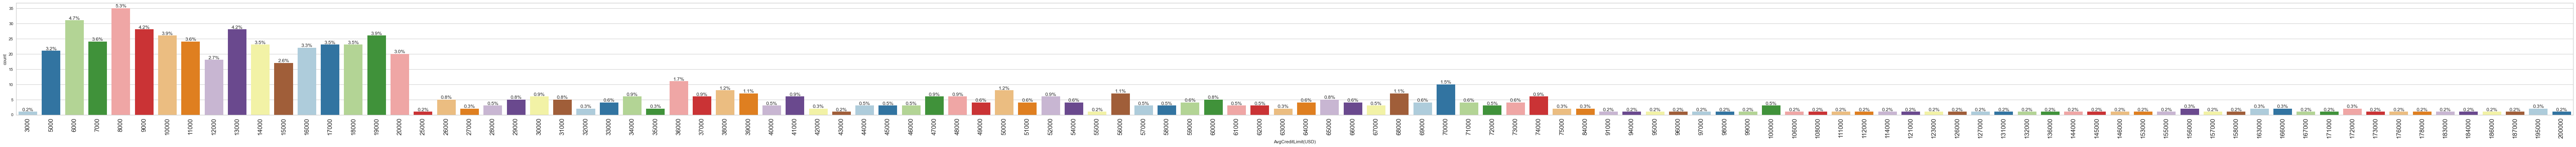

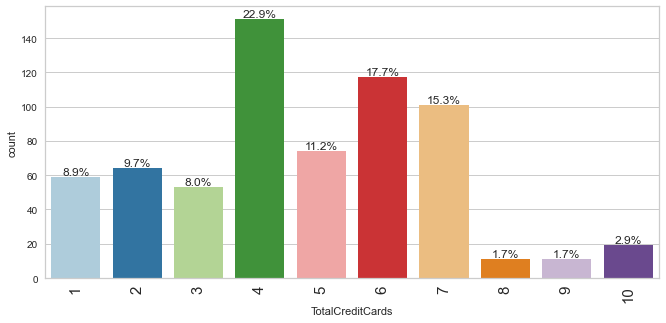

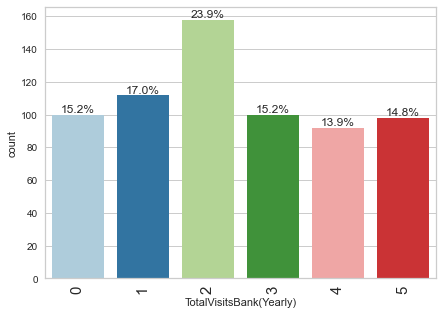

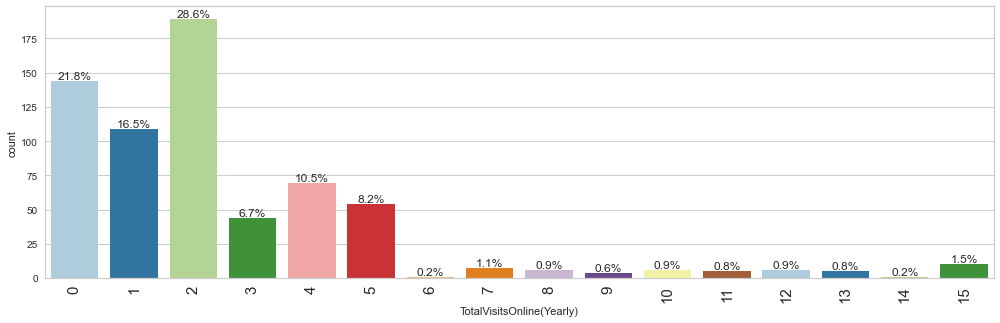

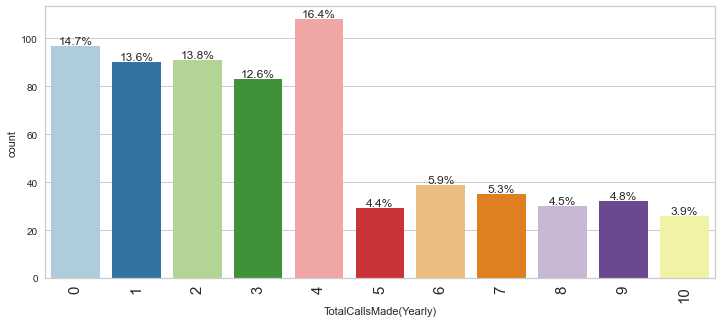

<IPython.core.display.Javascript object>

In [18]:
for item in num_col:
    labeled_barplot(df, item, perc=True)

**Observations**

- `Total Credit Cards`:  4 followed by 6 and 7 is the most popular choice.
- `Total Visits Bank`: 2 is the most common followed by 1 then 3
- `Total Visits Online`: Most customers here visit online twice, then the rest vist 0 times, once or more frequently.
- `Total Calls Made`: Most customers have called 4 times, the second most 0 times, and third most twice on a yearly basis.


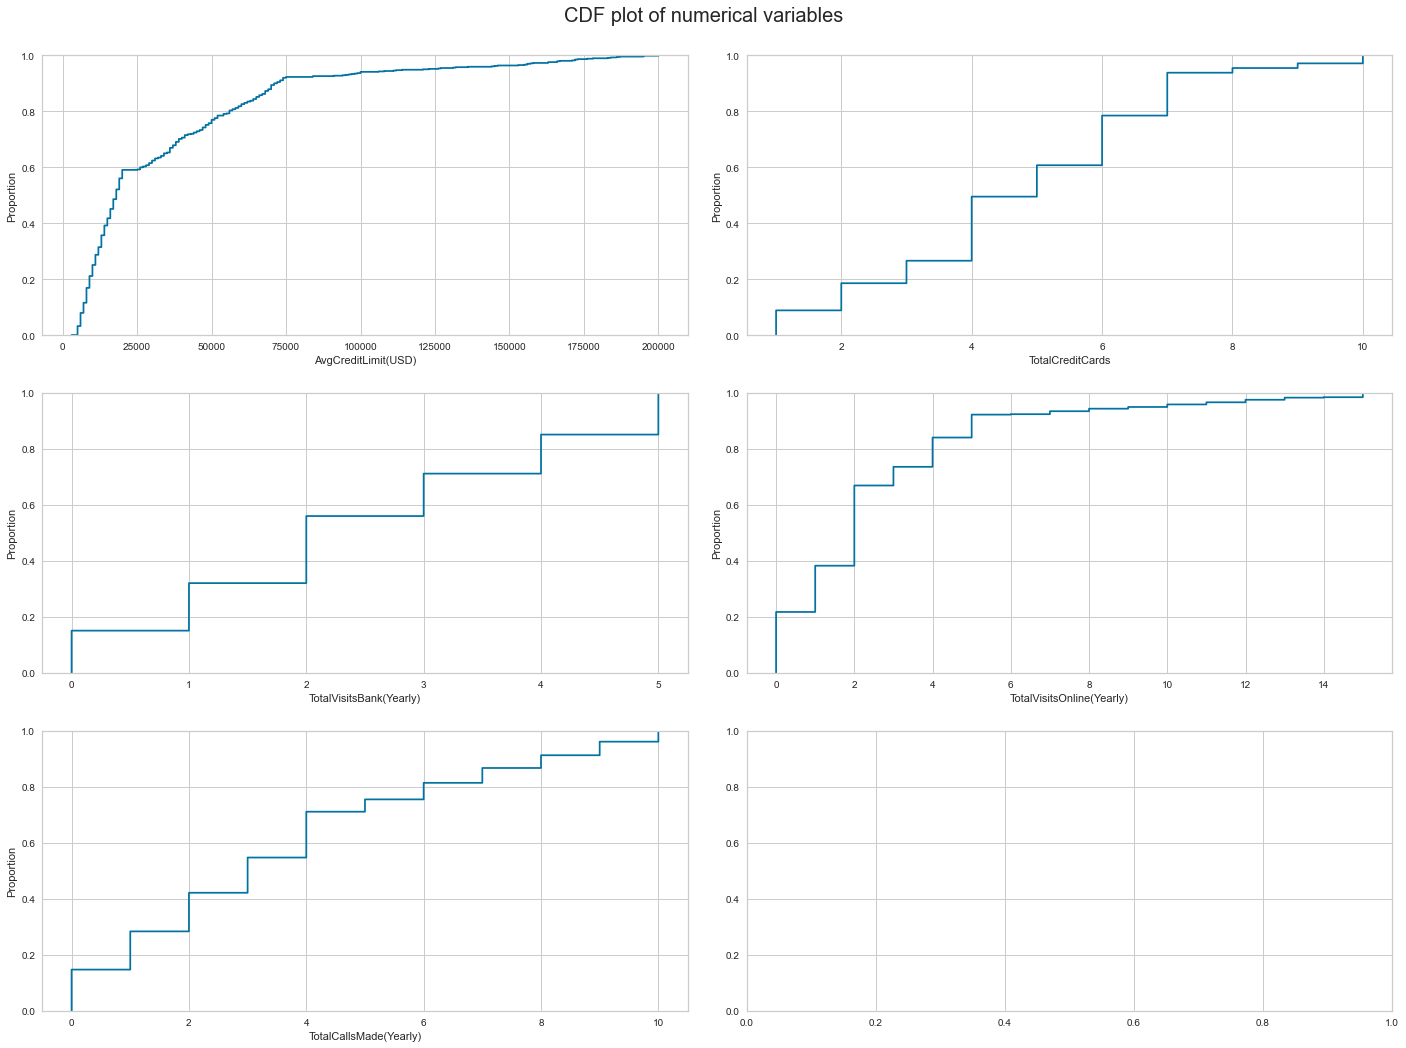

<IPython.core.display.Javascript object>

In [19]:
"""
An ECDF represents the proportion or count of observations falling below each
unique value in a dataset. Compared to a histogram or density plot, it has the
advantage that each observation is visualized directly, meaning that there are
no binning or smoothing parameters that need to be adjusted. It also aids direct
comparisons between multiple distributions. A downside is that the relationship
between the appearance of the plot and the basic properties of the distribution
(such as its central tendency, variance, and the presence of any bimodality)
may not be as intuitive.
"""
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

**Observations**

- 60% of the customers have average credit limits less than 25,000.
- 80% of the customers have a total credit card count of less 6.
- 80% of the customers have at least 4 total bank visits in a yearly schedule.
- 80% of the customers have a total online visits in a year basis below 4.
- Almost all customers have less than 6 total calls made yearly.

### Bivariate Visualizations

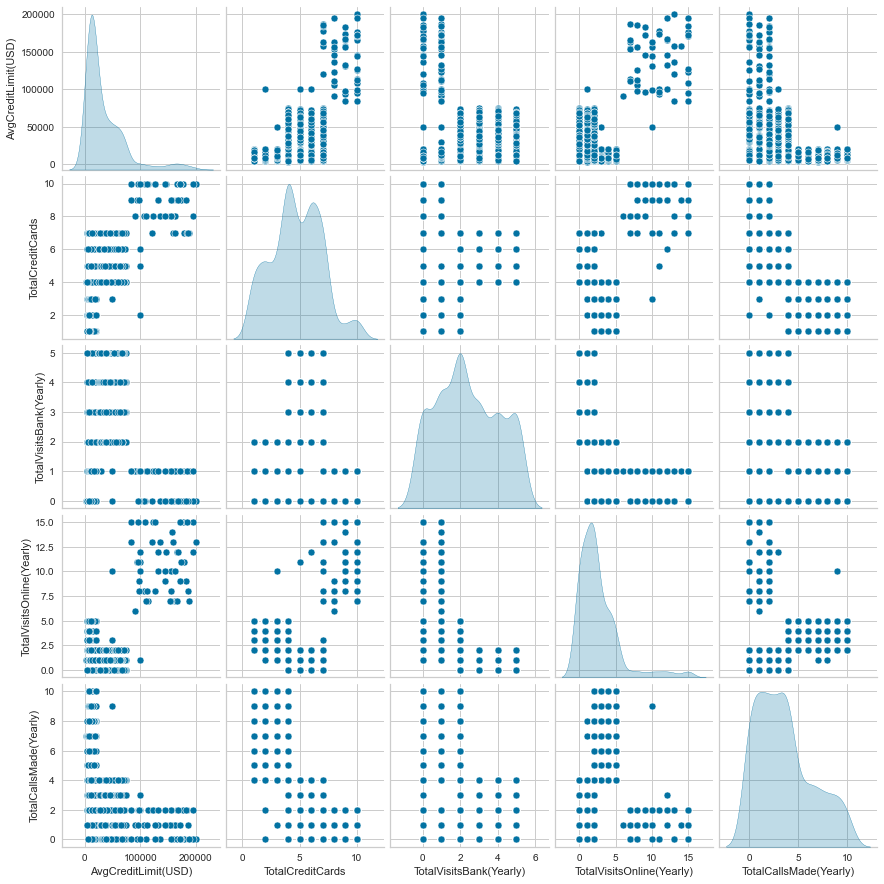

<IPython.core.display.Javascript object>

In [20]:
# show paired scatter plots with KDE in the middle
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**
1. There are no strong linearly related variables.
2. There are some subgroups noticed in the pairs. For instance, Total Vists online per year seems to be divided between those who make 5 or more and those who make 5 or less when looking at the total calls made yearly with those who make less than 5 online visits having higher yearly calls made to customer service at the bank.
 - Higher credit limit and cards points to higher use in the online banking.
 
3. The average credit limit seems to be divided by those who make 5 or less visits online yearly and those who make more, with those who make more have higher average credit spending limits.

### Inferential Relationships

Might want to drop any high correlations for clustering because it creates a redundancy in the information.

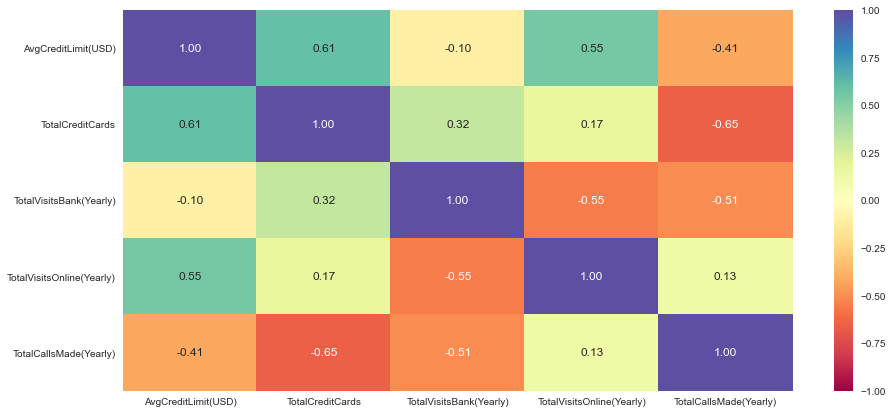

<IPython.core.display.Javascript object>

In [21]:
# create a heatmap from the correlation matrix
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observation**
- Total credit cards seems to be slightly correlated with average credit limit and slightly negatively correlated with total calls made per year.

- No other strong relationships seem to exist. Total vists online in any given year and the average credit limit are somewhat correlated as are total online vists and total bank vists. This might point to customers who tend to make contact with their bank as a matter of personality or temperment.

- There is a negative correlation that is slightly high between more card holdings showing lower calls to the bank.

- I will not say that any of these variables are so highly correlated that we can drop them for clustering analysis.

# Data Preprocessing

## Missing Value Treatment

In [22]:
# print columns
df.columns

Index(['AvgCreditLimit(USD)', 'TotalCreditCards', 'TotalVisitsBank(Yearly)',
       'TotalVisitsOnline(Yearly)', 'TotalCallsMade(Yearly)'],
      dtype='object')

<IPython.core.display.Javascript object>

In [23]:
# let's check how many customers have average credit limit of 0
(df["AvgCreditLimit(USD)"] == 0).sum()

0

<IPython.core.display.Javascript object>

In [24]:
# let's check the customers with no credit card
df[(df.TotalCreditCards == 0)]

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly)


<IPython.core.display.Javascript object>

- There are no customers who are mistakenly added to this dataset who don't have credit cards or a credit limit.
- We can move forward with this dataset for outlier dectection.

## Outlier Treatment

*From Great Learning*:

"You need to detect the outliers. And decide whether to treat them or not. Make sure the reasons are included in the submission. Generally, outliers *do* affect clustering techniques as the outliers may form their own cluster.

There is no one answer with regards to outliers and it depends upon several factors.

You can perform your analysis with and without outliers and see if there is any difference in the results. Sometimes there is no significant difference and in that case, there is no need to treat outliers. However, there may be a scenario where outliers can form separate segments which could be useful for the business.

You can also explore different distance measures, like Manhattan distance, which minimizes the effect of outliers.

<AxesSubplot:xlabel='AvgCreditLimit(USD)', ylabel='TotalCreditCards'>

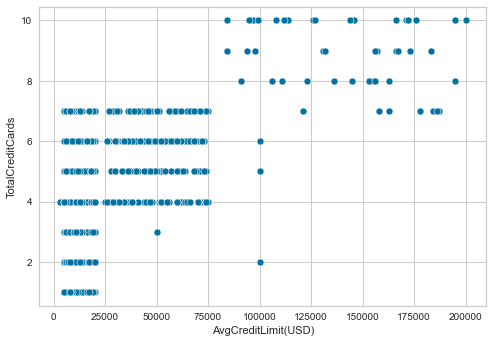

<IPython.core.display.Javascript object>

In [25]:
# make a scatter plot
sns.scatterplot(x=df["AvgCreditLimit(USD)"], y=df["TotalCreditCards"])

We seem to have a group of high average credit limit customers who have 7 or more cards. The limit seems to be above 75000.

In [27]:
# check the dataframe series for a condition
df[df["AvgCreditLimit(USD)"] > 75000]

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly)
0,100000,2,1,1,0
4,100000,6,0,12,3
6,100000,5,0,11,2
612,157000,9,1,14,1
613,94000,9,1,11,0
614,163000,8,1,7,1
615,131000,9,1,10,1
616,96000,10,1,11,2
617,136000,8,0,13,0
618,121000,7,0,13,2


<IPython.core.display.Javascript object>

We see a cutoff around 100k credit limit. These might be high-earners who qualify for high limits and we might want to keep them separate.

In [32]:
# get a sum from a series with a condition
(df["AvgCreditLimit(USD)"] > 75000).sum()

51

<IPython.core.display.Javascript object>

In [33]:
# get a percentage value of a number over the len of the dataframe
(50 / len(df)) * 100

7.575757575757576

<IPython.core.display.Javascript object>

We have ~8% of the overall data being sequestered by these outliers but they are clearly a subgroup in our data. Let's look at the other outliers.

<AxesSubplot:xlabel='TotalVisitsOnline(Yearly)'>

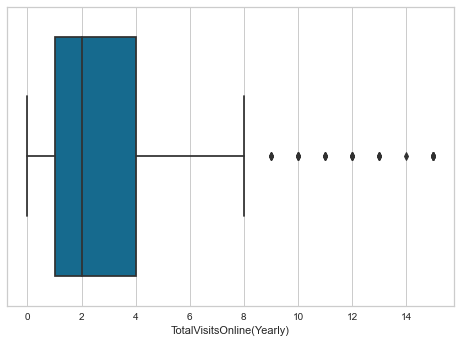

<IPython.core.display.Javascript object>

In [34]:
# make a scatter plot
sns.boxplot(data=df, x=df["TotalVisitsOnline(Yearly)"])

There is a split between those who have made above 8 yearly online vists and those who have not.

In [35]:
# get value counts
df["TotalVisitsOnline(Yearly)"].value_counts()

2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
8       6
10      6
12      6
11      5
13      5
9       4
6       1
14      1
Name: TotalVisitsOnline(Yearly), dtype: int64

<IPython.core.display.Javascript object>

There are 3 outlier groups: 9, 6, and 14. They total only 6 values for this variable. If we say that 6 is within the normal range of this varaible and get rid of the 4 customers who called 9 times or more, let's see what we would be dropping.

In [36]:
# show a sum based on a series with a condition
(df["Total_visits_online(Yearly)"] >= 9).sum()

KeyError: 'Total_visits_online(Yearly)'

<IPython.core.display.Javascript object>

In [37]:
# get a percentage value of a number over the len of the dataframe
(36 / len(df)) * 100

5.454545454545454

<IPython.core.display.Javascript object>

In [38]:
5.59 + 7.76

13.35

<IPython.core.display.Javascript object>

Dropping these outliers who make us lose ~6% of the data. Combined with dropping the average credit limit outliers we would lose 13% of the data which is significant since I see that 10% of the data is significant. 

<AxesSubplot:xlabel='AvgCreditLimit(USD)', ylabel='TotalVisitsOnline(Yearly)'>

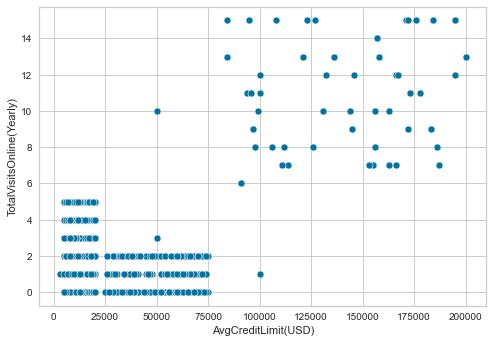

<IPython.core.display.Javascript object>

In [39]:
# make a scatter plot
sns.scatterplot(x=df["AvgCreditLimit(USD)"], y=df["TotalVisitsOnline(Yearly)"])

Combining them shows us that we have those customers who make 6 or more calls per year having a average credit limit above 75000 dollars which is a clear distinction of a grouping. With roughly 15% of the data lying in this group I will keep them as a separate group.

In [40]:
# subset the dataframe based on 2 conditions
df_outs = df.loc[
    (df["TotalVisitsOnline(Yearly)"] >= 7) & (df["AvgCreditLimit(USD)"] > 75000)
]

<IPython.core.display.Javascript object>

I will continue the clustering with the outliers and see what I come up with. It may pick up this sub-group and I may have to do the analysis again without the outliers.

### Using z-score

In [41]:
thres = 3  # cover 99% of data
out = {}
for cols in df.columns:
    i = df[cols]
    mean = np.mean(df[cols])
    std = np.std(df[cols])
    list1 = []
    for v in i:
        z = (v - mean) / std
        if np.absolute(z) > thres:
            list1.append(v)
    list1.sort()
    out[i.name] = list1

    for key, value in out.items():
        print("\n", key, ":", value)


 AvgCreditLimit(USD) : [153000, 155000, 156000, 156000, 157000, 158000, 163000, 163000, 166000, 166000, 167000, 171000, 172000, 172000, 173000, 176000, 178000, 183000, 184000, 186000, 187000, 195000, 195000, 200000]

 AvgCreditLimit(USD) : [153000, 155000, 156000, 156000, 157000, 158000, 163000, 163000, 166000, 166000, 167000, 171000, 172000, 172000, 173000, 176000, 178000, 183000, 184000, 186000, 187000, 195000, 195000, 200000]

 TotalCreditCards : []

 AvgCreditLimit(USD) : [153000, 155000, 156000, 156000, 157000, 158000, 163000, 163000, 166000, 166000, 167000, 171000, 172000, 172000, 173000, 176000, 178000, 183000, 184000, 186000, 187000, 195000, 195000, 200000]

 TotalCreditCards : []

 TotalVisitsBank(Yearly) : []

 AvgCreditLimit(USD) : [153000, 155000, 156000, 156000, 157000, 158000, 163000, 163000, 166000, 166000, 167000, 171000, 172000, 172000, 173000, 176000, 178000, 183000, 184000, 186000, 187000, 195000, 195000, 200000]

 TotalCreditCards : []

 TotalVisitsBank(Yearly) : [

<IPython.core.display.Javascript object>

## Duplicate Dectection

In [42]:
# let's check for duplicate observations
display(df.duplicated().sum())
display(df_outs.duplicated().sum())

11

0

<IPython.core.display.Javascript object>

- There are no duplicates.

## Feature Engineering

### Scaling

Here is a good discussion of why scaling is important for clustering: <a href="https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering">link</a>

In [43]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df.copy()
subset_scaled = scaler.fit_transform(subset)  # normalizing the features

<IPython.core.display.Javascript object>

In [44]:
# check the shape
subset_scaled.shape

(660, 5)

<IPython.core.display.Javascript object>

In [45]:
# checking the mean and standard deviation
np.mean(subset_scaled), np.std(subset_scaled)

(-3.014423727467092e-17, 1.0)

<IPython.core.display.Javascript object>

- The mean is much less than zero and the variance is nearly 1 as we normalized the data.

In [46]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

# Clustering

*From GreatLearning*:

"We would suggest after performing scaling, you can create a copy of the data frame, one to be used for K-means and the other to be used for Hierarchical. This would make it easier for you to work on both algorithms.

Cluster profiles inform you about the characteristics of different variables with respect to each cluster.

This can be done by first grouping the data based on the clusters formed, and then checking the summary statistics of the variables or visualizing the variable distributions for each group to gain insights.

(Hint: You can check the mean, median, and boxplot of each variable w.r.t clusters)"

In [47]:
# create data frames from other
hier_df = subset_scaled_df.copy()

<IPython.core.display.Javascript object>

## Hierarchical Clustering

In [48]:
# list of distance metrics
distance_metrics = [
    "euclidean",
    "chebyshev",
    "mahalanobis",
    "cityblock",
]  # cityblock = Manhattan

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

# set cophenet defaults
high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:  # two loops from distance metrics, for each
    for lm in linkage_methods:  # use the linkage methods listed in the list
        Z = linkage(
            hier_df, metric=dm, method=lm
        )  # function to take subset (scaled) pass the distance metric adn linkage use linkage method list
        c, coph_dists = cophenet(
            Z, pdist(hier_df)
        )  # use the cophenic correlation using Z and distance between each data point (set of distances between two points) against the dendogram distance
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c  # cophenet correlation value is c
            )
        )
        if high_cophenet_corr < c:  #
            high_cophenet_corr = c
            high_dm_lm[0] = dm  # best method is this distance metric
            high_dm_lm[1] = lm  # best method for linkage

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042137.
Cophenetic co

<IPython.core.display.Javascript object>

In [49]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

**Let's explore different linkage methods with Euclidean distance only.**

In [50]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hier_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(
        Z, pdist(hier_df, metric="euclidean")
    )  # set distance metric to be the same as the linkage method
    print(
        "Cophenetic correlation for Euclidean distance with {} linkage is {}.".format(
            lm, c
        )
    )
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance with single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance with complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance with average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance with centroid linkage is 0.8939385846326323.
Cophenetic correlation for Euclidean distance with ward linkage is 0.7415156284827493.
Cophenetic correlation for Euclidean distance with weighted linkage is 0.8861746814895477.


<IPython.core.display.Javascript object>

In [51]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

**Observations**

- We see that the cophenetic correlation is maximum with Euclidean distance and average linkage of close to .897.
- The Manhattan distance is not effected as much by outliers and gives us a only slightly less Cophenetic correlation for Cityblock distance and average linkage is 0.896.
- In third is the very close Cophenetic correlation for Chebyshev distance and average linkage is 0.895.


**Let's see the Euclidean distance dendrograms for the different linkage methods.**

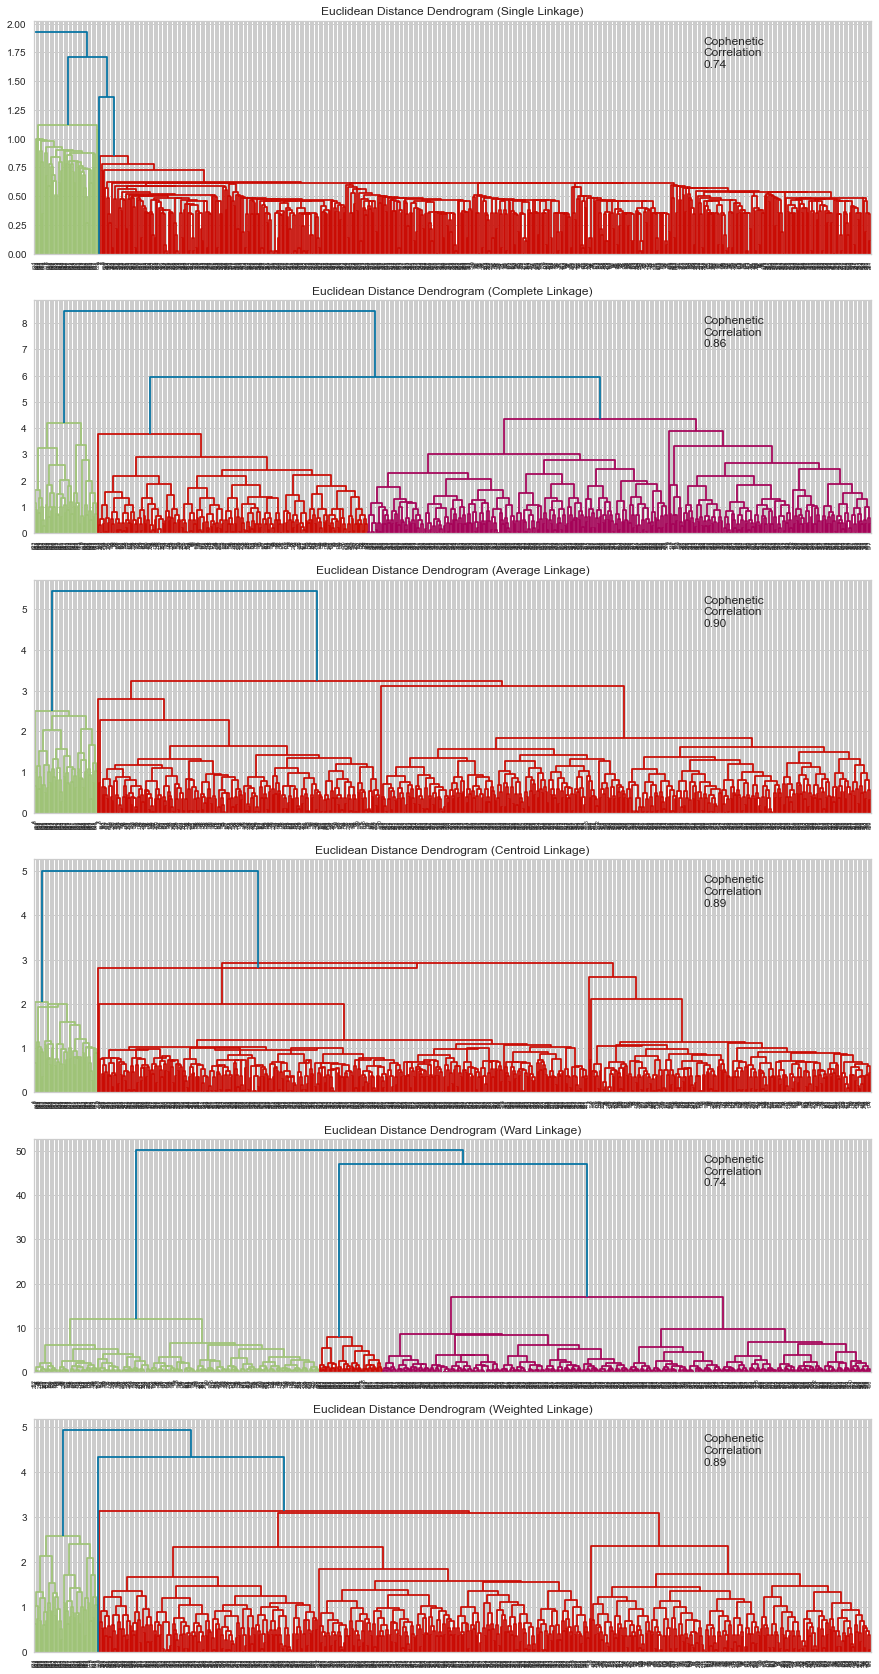

<IPython.core.display.Javascript object>

In [52]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hier_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])  # first plot use the first axis row
    axs[i].set_title(f"Euclidean Distance Dendrogram ({method.capitalize()} Linkage)")

    # calculate cophonet correlation using Z (hierarchical distances with that linkage method) and p-dist is correlation between two values
    coph_corr, coph_dist = cophenet(Z, pdist(hier_df, metric="euclidean"))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- Dendrogram for Ward and Complete linkage shows distinct and separate clusters while Ward shows fewer higher-level groupings.
- Dendrogram for Single linkage show only 3 primary groupings.
- Dendrogram for Average linkage shows a high cophenetic correlation but only 3 distinct groupings.

**Let's see the dendrogram for Chebyshev and Manhattan distances with average and weighted linkage methods as they gave high cophenetic correlation values.**

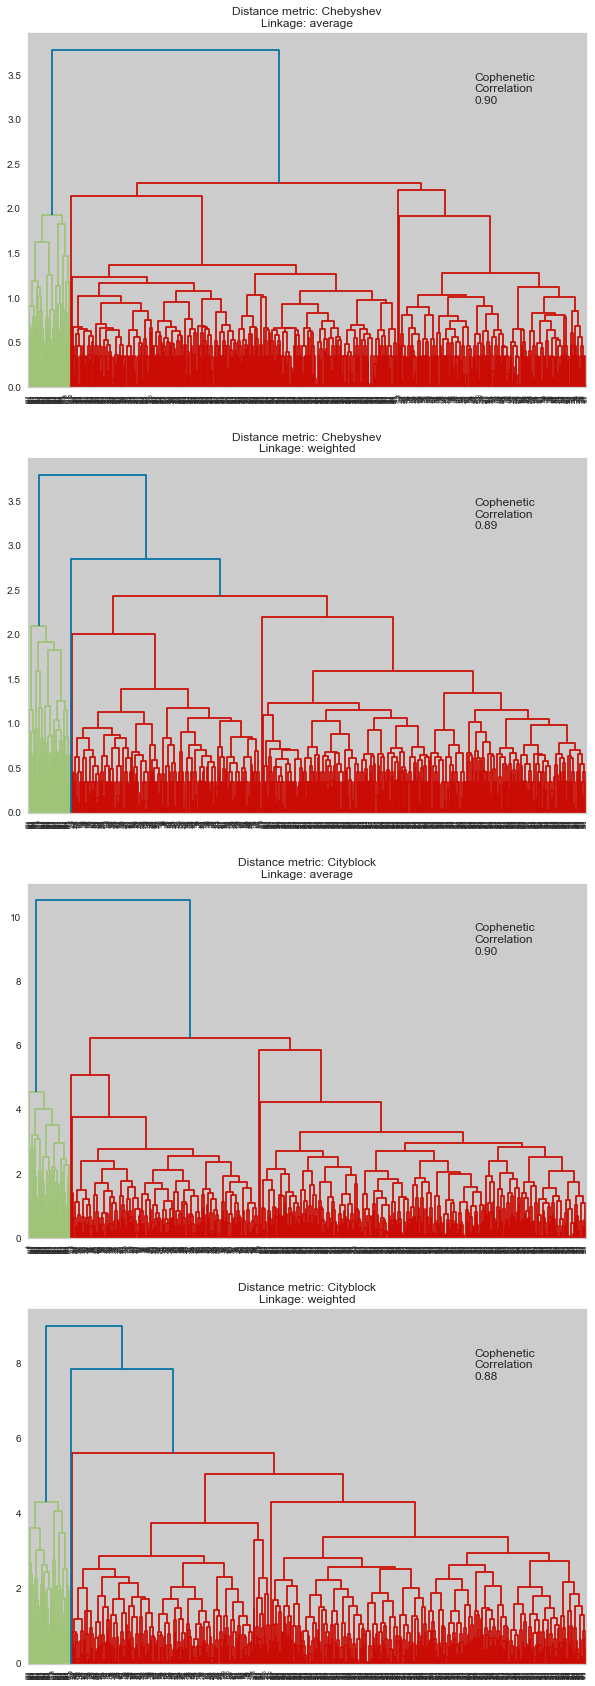

<IPython.core.display.Javascript object>

In [53]:
# list of distance metrics
distance_metrics = ["chebyshev", "cityblock"]

# list of linkage methods
linkage_methods = ["average", "weighted"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hier_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(hier_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

**Observations**

- Out of all the dendrograms we saw, it is clear that the dendrogram with Euclidean distance and Ward linkage, Chebyshev with weighted linkage, Complete and Weighted Linkage (with CityBlock method) allows us to see 3 distinct groups.

- The CityBlock metric appears to capture the distinct in the outliers mentioned earlier but the number of groups is the same and after further review produces nearly identical splits as the Euclidean.

- 3 would be the appropriate number of the clusters from the dendrogram with complete linkage method to the get the greatest variance in the groups.

**Let's create 3 clusters using complete linkage which shows 3 distinct groups.**

In [54]:
# build a hierarchical clustering model usign the agglomerative technique
HCmodel = AgglomerativeClustering(
    n_clusters=3, affinity="euclidean", linkage="complete"
)
HCmodel.fit(hier_df)  # fit the model on the data

AgglomerativeClustering(linkage='complete', n_clusters=3)

<IPython.core.display.Javascript object>

In [55]:
# adding hierarchical cluster labels to the original and scaled dataframes
hier_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

In [56]:
# check dataframe head
df.head()

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly),HC_Clusters
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1


<IPython.core.display.Javascript object>

*From GreatLearning*
"We would suggest you calculate the silhouette score for different numbers of clusters obtained from hierarchical clustering and make a simple line chart to show where is the highest silhouette score. This would help you to decide how many clusters should be made."

For n_clusters = 2, silhouette score is 0.5330845828114943
For n_clusters = 3, silhouette score is 0.5812681790546261
For n_clusters = 4, silhouette score is 0.34716326727740904
For n_clusters = 5, silhouette score is 0.3207362807865595
For n_clusters = 6, silhouette score is 0.3183871593636158
For n_clusters = 7, silhouette score is 0.2814460630363718
For n_clusters = 8, silhouette score is 0.279889824811452
For n_clusters = 9, silhouette score is 0.25895006361188727


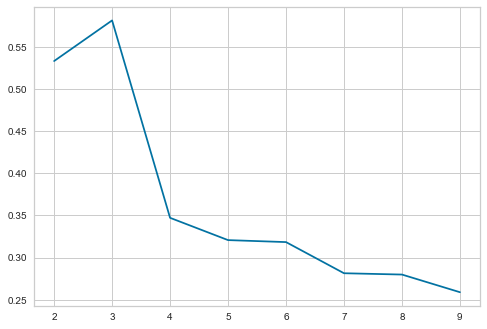

<IPython.core.display.Javascript object>

In [57]:
# calculate silhouette score for h-clusters
# return Mean Silhouette Coefficient for all samples.
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="euclidean", linkage="complete"
    )
    preds = clusterer.fit_predict((hier_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(hier_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

I will examine the profile of the clusters when comparing to the k-means clustering technique using 3 groups.

## K-Means Clustering

In [58]:
# create data frames from other
k_means_df = subset_scaled_df.copy()

<IPython.core.display.Javascript object>

C:\Users\Joe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9426543606899347
Number of Clusters: 7 	Average Distortion: 0.9093991915419353
Number of Clusters: 8 	Average Distortion: 0.8843243844476886


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

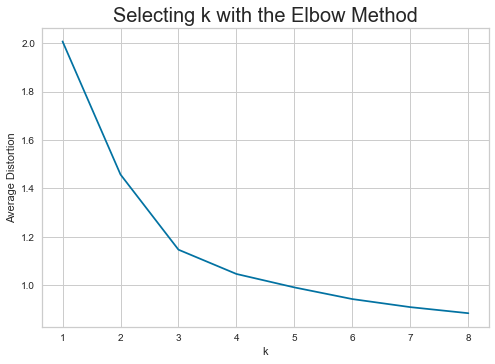

<IPython.core.display.Javascript object>

In [59]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)  # change cluster value for 1 - 9
    model.fit(k_means_df)
    prediction = model.predict(k_means_df)
    distortion = (
        sum(np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis=1))
        / k_means_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

# create an elbow graph
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 2 or 3.**

**Let's check the silhouette scores.**

*From GreatLearning*:

"The silhouettevisualizer of the yellowbrick library is only designed for k-means clustering. It does not support HC algorithms. Also, there is no such open-source library to make a similar plot of silhouette score for HC algorithms."

For n_clusters = 2, silhouette score is 0.41842496663230405
For n_clusters = 3, silhouette score is 0.5157182558882754
For n_clusters = 4, silhouette score is 0.355667061937737
For n_clusters = 5, silhouette score is 0.2717470361094591
For n_clusters = 6, silhouette score is 0.25545029453735185
For n_clusters = 7, silhouette score is 0.2303720243872446
For n_clusters = 8, silhouette score is 0.22792951895015612
For n_clusters = 9, silhouette score is 0.21948558630916062


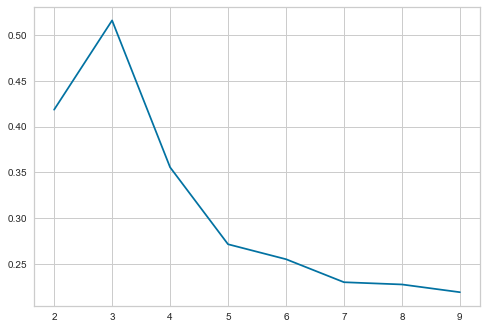

<IPython.core.display.Javascript object>

In [61]:
# print the silhouette score and elbow curve
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((k_means_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 3 is a good value of k.**

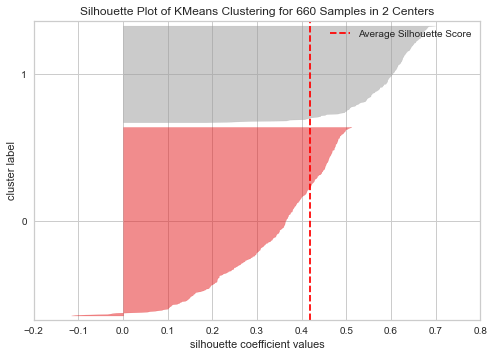

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [62]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

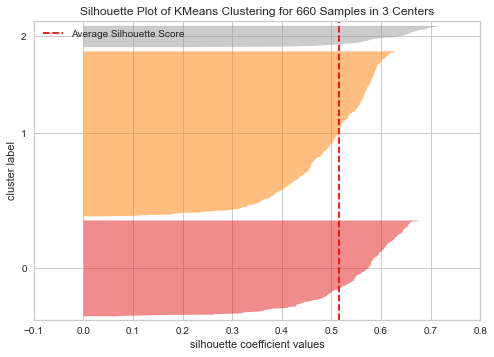

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [63]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

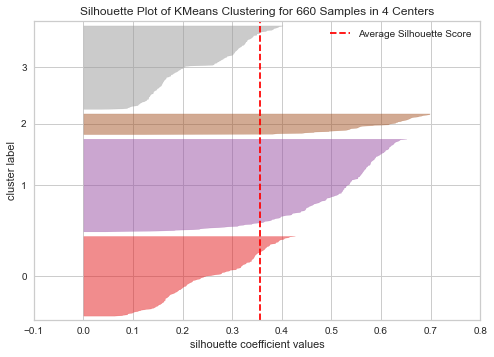

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [64]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

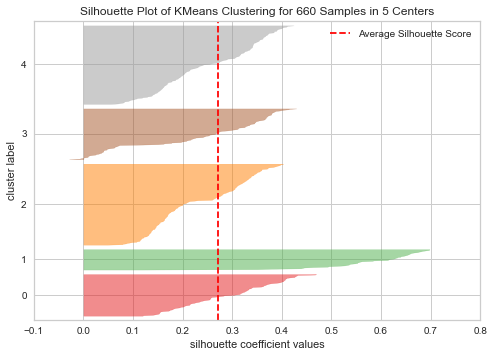

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [65]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

**Let's take 3 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 3 in the elbow curve.**

- Our range of silhouette scores is from .5 @ 3 groups to ~.28 @ 6 groups

- We see in 5 cluster that group 1 shows a very high score.

- With 4 clusters group 2 would have a very high score.

# Compare Clustering Methods and Profiles

Summary statistics of the variables or visualizing the variable distributions for each group to gain insights.

## Hierarchial Cluster Profiling

In [90]:
# create subset of clusters by mean
cluster_profile = df.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

Let's check our outliers from the average credit limit to see if those higher ranges were included.

In [91]:
# create a column in dataframe with the values from the clusters by average credit limit
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["AvgCreditLimit(USD)"].count().values
)

<IPython.core.display.Javascript object>

Let's examine the groupings by the mean of each column to check for clear and reasonable groupings.

In [92]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly),K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,33151.133501,5.460957,3.405542,1.010076,2.060453,0.972292,397
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12234.741784,2.352113,0.957746,3.633803,7.009390,0.000000,213


<IPython.core.display.Javascript object>

- Our higher average credit limit customers seem to have fallen into group 2. The split is slightly lower than I would hope at range of ~35k to 141k in the mean which could just be because those outliers are pulling it higher. At 49 records in the segement it is using up all of the 50 that we found earlier.

- We clearly do not have have even split in the groups with the majority falling into group 0 and group 2 being our outliers with the higher means.

**Let's compare Cluster vs average credit limit**

In [93]:
# let's see the names of the countries in each cluster
for cl in df["HC_Clusters"].unique():
    print("In cluster {}, the following online visits (yearly) are present:".format(cl))
    print(df[df["HC_Clusters"] == cl]["TotalVisitsOnline(Yearly)"].unique())
    print()

In cluster 0, the following online visits (yearly) are present:
[1 3 2 0]

In cluster 2, the following online visits (yearly) are present:
[10  1  5  2  4  3]

In cluster 1, the following online visits (yearly) are present:
[12 11 14  7 10 13 15  6  8  9]



<IPython.core.display.Javascript object>

In [94]:
# make crosstab of a series with highlighting
pd.crosstab(df.HC_Clusters, df["TotalVisitsOnline(Yearly)"]).style.highlight_max(
    color="lightgreen", axis=0
)

TotalVisitsOnline(Yearly),0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
HC_Clusters,,,,,,,,,,,,,,,,
0,144,107,144,2,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10
2,0,2,45,42,69,54,0,0,0,0,1,0,0,0,0,0


<IPython.core.display.Javascript object>

We see that there is some overlap between clusters. Cluster 1 has the strange addition of 1,2 and 10 visits whereas I would expect it to be in the range of 4 - 8 or 3 - 6. The means are showing in normal groupings though as shown from the boxplot in the univariate analysis.

### Viewing the groupings

In [95]:
# selecting numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

<IPython.core.display.Javascript object>

IndexError: index 2 is out of bounds for axis 0 with size 2

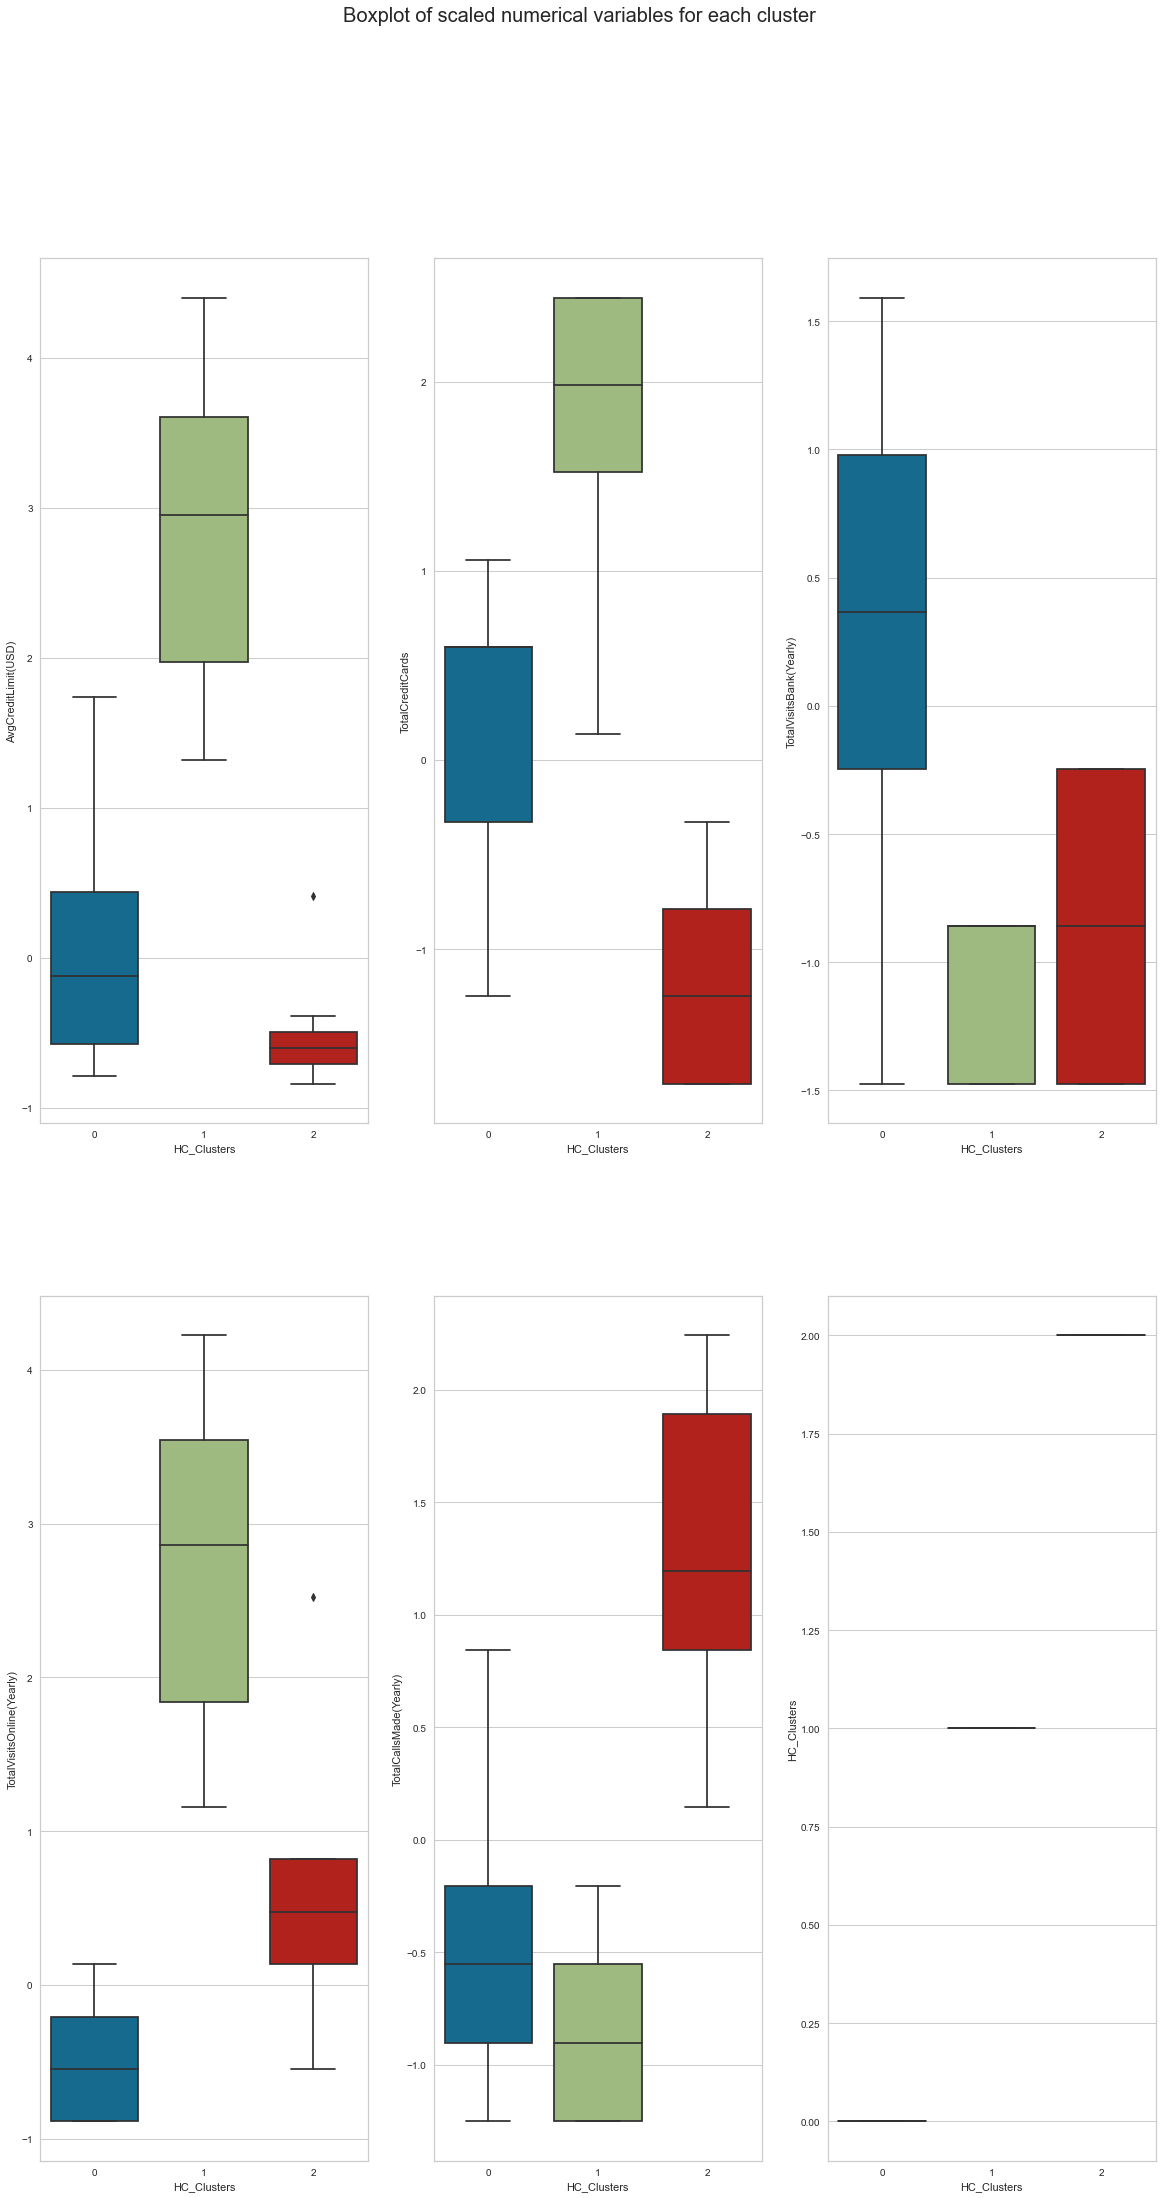

<IPython.core.display.Javascript object>

In [96]:
# Create figures with boxplots
fig, axes = plt.subplots(2, 3, figsize=(20, 35))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii][0], y=hier_df[num_cols[counter]], x=hier_df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][1], y=hier_df[num_cols[counter]], x=hier_df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][2], y=hier_df[num_cols[counter]], x=hier_df["HC_Clusters"],
    )
    counter = counter + 1


fig.tight_layout(pad=2.0)

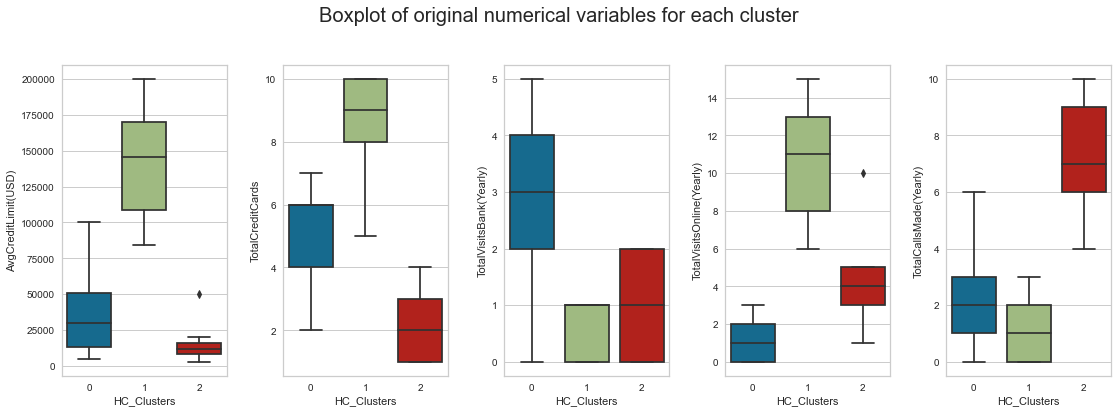

<IPython.core.display.Javascript object>

In [98]:
# Create figures with boxplots
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_cols[counter]], x=df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Insights

- **Cluster 2: <a href="https://www.google.com/search?q=typical+american+credit+limit&oq=typical+american+credit+limit&aqs=chrome..69i57.4032j0j1&sourceid=chrome&ie=UTF-8">Typical American</a>**:
    - This cluster contains low-average credit limit customers with a low total online visits per year at around 1.
    - Total Credit Cards is between 4 - 6 on the norm.
    - Total visits to the bank per year is between 2 - 5 on the extremes.
    

- **Cluster 0: High Risk Users**
    - Average credit limit is very low below 25k and total cards is around 2.
    - Total bank visits ranges from 0 - 2 and average online vists is lower at 3 - 4.
    - Total calls made to the bank is the highest of the clusters at around an average of 7 per year.
    

- **Cluster 1: Good Credit Keepers**
    - This cluster is the higher end of average limit, total cards, and online visits.
    - Total calls per year and visits to the bank is lower at or below 2.
    - These are low-touch,high-use customers.

## K-Means Clustering Profile

In [99]:
# set Kmeans clustering algorithm and fit
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(k_means_df)

KMeans(n_clusters=3, random_state=1)

<IPython.core.display.Javascript object>

In [100]:
# adding kmeans cluster labels to the original dataframe and scaled df
df["K_means_segments"] = kmeans.labels_
k_means_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

In [101]:
# view head
k_means_df.head()

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly),K_means_segments
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,1
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,0
2,0.410293,1.058973,-0.860451,0.134290,0.145528,1
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,1
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,2


<IPython.core.display.Javascript object>

In [102]:
# view stats
k_means_df.describe()

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly),K_means_segments
count,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02,660.000000
mean,8.195465e-16,-4.006223e-15,1.157323e-16,1.944572e-16,-7.112156e-16,0.736364
std,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00,0.588364
min,-8.398081e-01,-1.710864e+00,-1.473731e+00,-8.883795e-01,-1.251537e+00,0.000000
25%,-6.536229e-01,-7.875852e-01,-8.604506e-01,-5.474897e-01,-9.022711e-01,0.000000
50%,-4.408398e-01,1.356941e-01,-2.471705e-01,-2.065999e-01,-2.037386e-01,1.000000
75%,3.570968e-01,5.973337e-01,9.793898e-01,4.751797e-01,4.947938e-01,1.000000
max,4.399975e+00,2.443892e+00,1.592670e+00,4.224968e+00,2.241125e+00,2.000000


<IPython.core.display.Javascript object>

In [103]:
# groupby dataframe on means of a column
cluster_profile_k = df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [104]:
# do a groupby function
cluster_profile_k["count_in_each_segment"] = (
    df.groupby("K_means_segments")["TotalVisitsOnline(Yearly)"].count().values
)

<IPython.core.display.Javascript object>

In [105]:
# let's display cluster profiles
cluster_profile_k.style.highlight_max(color="lightgreen", axis=0)

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly),HC_Clusters,count_in_each_segment
K_means_segments,,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,1.901786,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,0.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,1.000000,50


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='K_means_segments'>

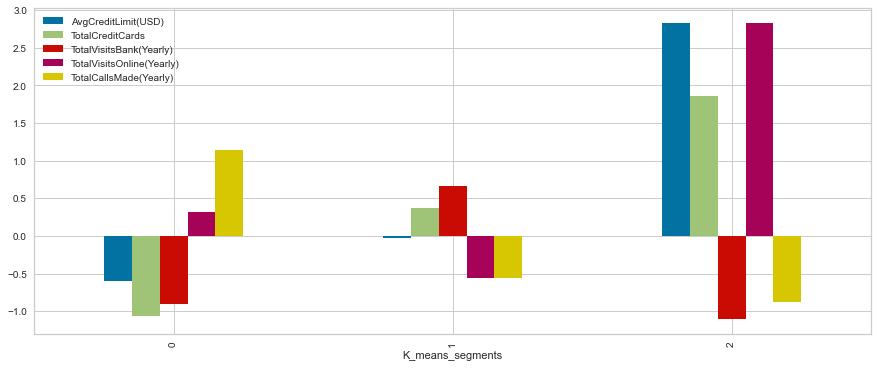

<IPython.core.display.Javascript object>

In [106]:
# do a groupby with means
k_means_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

In [108]:
# make crosstab of a series with highlighting
pd.crosstab(
    df["K_means_segments"], df["TotalVisitsOnline(Yearly)"]
).style.highlight_max(color="lightgreen", axis=0)

TotalVisitsOnline(Yearly),0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
K_means_segments,,,,,,,,,,,,,,,,
0,0,3,54,43,69,54,0,0,0,0,1,0,0,0,0,0
1,144,106,135,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10


<IPython.core.display.Javascript object>

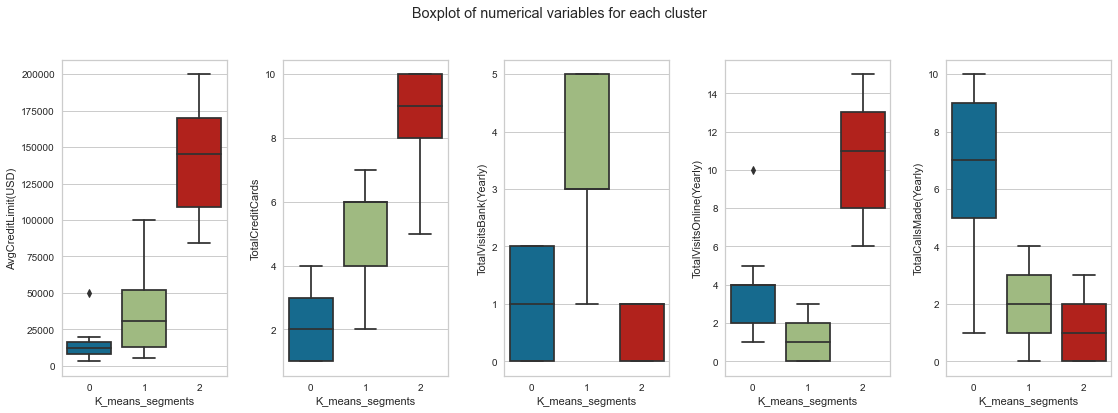

<IPython.core.display.Javascript object>

In [107]:
# create boxplots for each feature
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_cols[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

- **Cluster 2: Amazon Shoppers**:
    - Higher average credit users,total cards, and total online visits so low risk and high usage folks.
    - Total bank visits are low as well as total calls to the bank.
    - The K-means is capturing a good chunk of the hierarchical clustering groupings.


- **Cluster 1: In-Person Users**:
    - Low to negative average credit limit, online and total calls made per year.
    - Total bank visits is the highest of the 3 groupings.
    - Total credit cards is moderate to low at 4 -6.


- **Cluster 0: High Touch Customers**:
    - Have the highest total calls made per year of the three groups.
    - Do a fair amount of online banking.
    - Do a moderate amount of bank visits.
    - Have the lowest amount of credit cards and credit limit.


## Compare the Clustering Techniques

1. Which clustering technique took less time for execution?
2. Which clustering technique gave you more distinct clusters, or are they the same?
3. What any differences you obtained in the cluster profiles from both of the clustering techniques?
4. How do the silhouette scores vary?
5. How many observations are there in the similar clusters of both algorithms?
6. How many clusters are obtained as the appropriate number of clusters from both algorithms?

**Responses:**
1. The K-means technique.
2. They are the same in their distributions because of use of euclidean distance metric used in both.
3. The hierarchical cluster took the outlier in the total bank visits feature that appears in the k-means cluster and incorporated it into a group. There are no other noticeable differences in the way that the groupings were distributed. They are basically the same but in different cluster numbers.
4. The H-cluster with 3 clusters scored a 0.54 and the K-Means with 3 clusters scored at 0.52.
5. They are only off by 2 records in the cluster difference.
6. 3

In [109]:
# let's display cluster profiles
display(
    "Hierarchical profiling",
    cluster_profile.style.highlight_max(color="lightgreen", axis=0),
)

# let's display cluster profiles
display(
    "K-means profiling",
    cluster_profile_k.style.highlight_max(color="lightgreen", axis=0),
)

'Hierarchical profiling'

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly),K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,33151.133501,5.460957,3.405542,1.010076,2.060453,0.972292,397
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12234.741784,2.352113,0.957746,3.633803,7.009390,0.000000,213


'K-means profiling'

,AvgCreditLimit(USD),TotalCreditCards,TotalVisitsBank(Yearly),TotalVisitsOnline(Yearly),TotalCallsMade(Yearly),HC_Clusters,count_in_each_segment
K_means_segments,,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,1.901786,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,0.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,1.000000,50


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Observations per cluster are nearly identical')

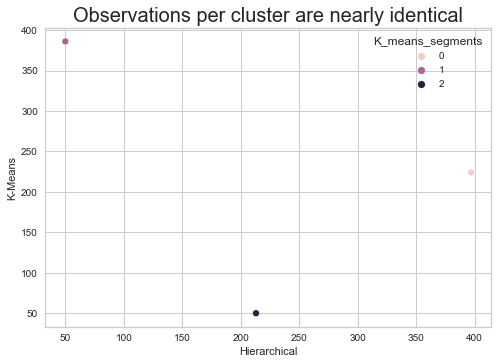

<IPython.core.display.Javascript object>

In [110]:
# create a scatterplot with legend
sns.scatterplot(
    x=cluster_profile.count_in_each_segments,
    y=cluster_profile_k.count_in_each_segment,
    hue=cluster_profile_k.index,
)
plt.xlabel("Hierarchical")
plt.ylabel("K-Means")
plt.title("Observations per cluster are nearly identical", fontsize=20)

In [111]:
# print the cluster profile index
cluster_profile.index

Int64Index([0, 1, 2], dtype='int64', name='HC_Clusters')

<IPython.core.display.Javascript object>

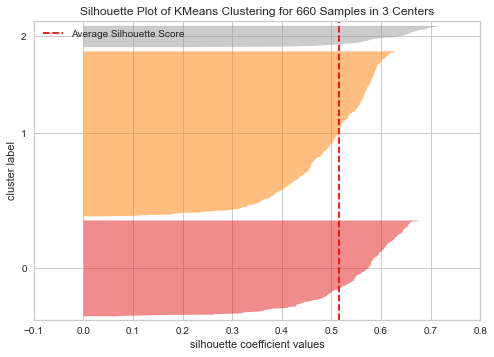

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [112]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

# Business Recommendations

For both clustering techniques since the outcomes were very similar.

- **Average American**: Incentivize the use of their credit limit and offer reasons to interact with the banks, i.e., to purchase more credit, get another card, or look at other services. 


- **"Watch-Out**: Keep an eye-out for these users who are riskier credit users and yet take up the banks time. Look for ways to ameliorate their bad credit by offering credit assitance, protection, and special deals. 


- **Good Credit Users**: Keep offering them cards and good credit limits to keep them coming back for more. 
